# General Note
In order to guide you through the homework, we put "...COMPLETE HERE..." as placeholder for you to complete the homework.

In [1]:
%matplotlib inline


# Classifying Names with a Character-Level RNN

We will biuld and train a character-level *Recurrent Neural
Network* (*RNN*) to classify words.

A character-level RNN reads words as a series of characters -
it outputs a prediction and hidden state at each step, and feeds the
previous hidden state into each next step. We take the final prediction
to be the output, that represents which class the word belongs to.

We want to predict the Language class to which belongs the Surnames.

## Preparing the Data

We will create a dictionary of lists of names per language,
``{language: [names ...]}``.


In [2]:
!git clone https://github.com/sarafrr/pytorch-tutorial-nlp-public.git

Cloning into 'pytorch-tutorial-nlp-public'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 100 (delta 39), reused 81 (delta 23), pack-reused 0
Receiving objects: 100% (100/100), 1.55 MiB | 8.75 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [3]:
# general import

import os
from glob import glob
from io import open
import string
import numpy as np
import random
import torch
import torch.nn as nn

In [4]:
def getFiles(path):
  return glob(path)

file_list = getFiles('./data/Names/*.txt')
print(file_list[:2])

['./data/Names/French.txt', './data/Names/German.txt']


In [5]:
!rm -r pytorch-tutorial-nlp-public/

In [6]:
# read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

print(readLines(file_list[0]))
print(readLines(file_list[1]))

['Abel', 'Abraham', 'Adam', 'Albert', 'Allard', 'Archambault', 'Armistead', 'Arthur', 'Augustin', 'Babineaux', 'Baudin', 'Beauchene', 'Beaulieu', 'Beaumont', 'Bélanger', 'Bellamy', 'Bellerose', 'Belrose', 'Berger', 'Béringer', 'Bernard', 'Bertrand', 'Bisset', 'Bissette', 'Blaise', 'Blanc', 'Blanchet', 'Blanchett', 'Bonfils', 'Bonheur', 'Bonhomme', 'Bonnaire', 'Bonnay', 'Bonner', 'Bonnet', 'Borde', 'Bordelon', 'Bouchard', 'Boucher', 'Brisbois', 'Brodeur', 'Bureau', 'Caron', 'Cavey', 'Chaput', 'Charbonneau', 'Charpentier', 'Charron', 'Chastain', 'Chevalier', 'Chevrolet', 'Cloutier', 'Colbert', 'Comtois', 'Cornett', 'Coté', 'Coupe', 'Courtemanche', 'Cousineau', 'Couture', 'Daniau', "D'aramitz", 'Daviau', 'David', 'Deforest', 'Degarmo', 'Delacroix', 'De la fontaine', 'Deniau', 'Deniaud', 'Deniel', 'Denis', 'De sauveterre', 'Deschamps', 'Descoteaux', 'Desjardins', 'Desrochers', 'Desrosiers', 'Dubois', 'Duchamps', 'Dufort', 'Dufour', 'Duguay', 'Dupond', 'Dupont', 'Durand', 'Durant', 'Duval',

In [7]:
# category_words is a dict with the key as the language
# and the value a list with all the possible names in the specific language
category_words = {}
all_categories = []
alphabet = set()

for filename in file_list:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    for word in lines:
      alphabet |= set(word)
    category_words[category] = lines

# letter to index
l_to_i = dict(zip(alphabet, range(len(alphabet))))
print(category_words)
n_categories = len(all_categories)
print(f'N. of languages: {n_categories}')
print(l_to_i)
n_letters = len(l_to_i)
print(f'The alphabet has {n_letters} letters')

{'French': ['Abel', 'Abraham', 'Adam', 'Albert', 'Allard', 'Archambault', 'Armistead', 'Arthur', 'Augustin', 'Babineaux', 'Baudin', 'Beauchene', 'Beaulieu', 'Beaumont', 'Bélanger', 'Bellamy', 'Bellerose', 'Belrose', 'Berger', 'Béringer', 'Bernard', 'Bertrand', 'Bisset', 'Bissette', 'Blaise', 'Blanc', 'Blanchet', 'Blanchett', 'Bonfils', 'Bonheur', 'Bonhomme', 'Bonnaire', 'Bonnay', 'Bonner', 'Bonnet', 'Borde', 'Bordelon', 'Bouchard', 'Boucher', 'Brisbois', 'Brodeur', 'Bureau', 'Caron', 'Cavey', 'Chaput', 'Charbonneau', 'Charpentier', 'Charron', 'Chastain', 'Chevalier', 'Chevrolet', 'Cloutier', 'Colbert', 'Comtois', 'Cornett', 'Coté', 'Coupe', 'Courtemanche', 'Cousineau', 'Couture', 'Daniau', "D'aramitz", 'Daviau', 'David', 'Deforest', 'Degarmo', 'Delacroix', 'De la fontaine', 'Deniau', 'Deniaud', 'Deniel', 'Denis', 'De sauveterre', 'Deschamps', 'Descoteaux', 'Desjardins', 'Desrochers', 'Desrosiers', 'Dubois', 'Duchamps', 'Dufort', 'Dufour', 'Duguay', 'Dupond', 'Dupont', 'Durand', 'Durant

In [8]:
# this is all the necessary code to set the seed
def set_seed(seed : int = 123):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

In [9]:
set_seed()

### Turning Names into Tensors

As always, we have to convert textual data into tensors.

To represent a single letter, we use a "one-hot vector" of size
``(1 x n_letters)``, where 1 is the respective index of the letter it is representing.

To make a word we combine a bunch of those representations into a 2D matrix
``(word_length x 1 x n_letters)``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here, for the sake of simplicity.




# Question 1
Create the auxiliary function to process the data to have the input suitable for `nn.Embedding`. This is because one of the following questions will be to try not to use one-hot-encoding representation, but use the embedding layer instead.

In [10]:
def letterToIndex(letter):
  '''
  Returns the index of a letter in the alphabet
  '''
  return l_to_i[letter]

def wordToOneHotTensor(word):
  '''
  Returns the word in zero-hot encoding
  '''
  tensor = torch.zeros(len(word), 1, n_letters).long()
  for idx, let in enumerate(word):
      tensor[idx][0][letterToIndex(let)] = 1
  return tensor

def wordToEmbedding(word):
  indexes = [letterToIndex(letter) for letter in word]
  return torch.tensor(indexes, dtype=torch.long)

tmp = 'Aarle'

print(f'N. of letters {len(alphabet)}')
print(f'Length of the word {len(tmp)}\n')
print(wordToOneHotTensor(tmp).size())
print(wordToOneHotTensor(tmp))
print('\n')
print(wordToEmbedding(tmp).size())
print(wordToEmbedding(tmp))

N. of letters 87
Length of the word 5

torch.Size([5, 1, 87])
tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0

# Question 2
Implement the Vanilla RNN considering a batch size of dimension 1 (the simplest case).

## Creating the Network

Here, we are going to create RNNs with one only layer for the sake of simplicity. However, these models can be easily expanded to the more general case of having more layers.  

The Vanilla RNN is just 2 linear layers which operate on an input and hidden state.




In [11]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, type_layer):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.type_layer = type_layer

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

In [87]:
class RNNEmb(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, type_layer):
    super(RNNEmb, self).__init__()

    self.hidden_size = hidden_size
    self.type_layer = type_layer

    self.embedding = nn.Embedding(input_size, hidden_size)

    self.e2h = nn.Linear(hidden_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self, input, hidden):
    embedded = self.embedding(input)
    combined = torch.cat((torch.unsqueeze(embedded, 0), hidden), 1)
    hidden = self.e2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

# Question 3
Implement an LSTM cell considering a batch size of dimension 1 (the simplest case).

In [28]:
class LSTM(torch.nn.Module):


    def __init__(self, input_length, hidden_length, type_layer):
        super(LSTM, self).__init__()

        self.input_length = input_length
        self.hidden_length = hidden_length
        self.type_layer = type_layer

        # forget gate components
        self.linear_forget_w1 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_forget_r1 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid_forget = nn.Sigmoid()

        # input gate components
        self.linear_gate_w2 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_gate_r2 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid_gate = nn.Sigmoid()

        # cell memory components
        self.linear_gate_w3 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_gate_r3 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.activation_gate = nn.Tanh()

        # out gate components
        self.linear_gate_w4 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_gate_r4 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid_hidden_out = nn.Sigmoid()

        self.activation_final = nn.Tanh()
        self.log_softmax = nn.LogSoftmax(dim=1)


    def forget(self, x, h):
        x = self.linear_forget_w1(x)
        h = self.linear_forget_r1(h)
        return self.sigmoid_forget(x + h)


    def input_gate(self, x, h):
        # Equation 1. input gate
        x_temp = self.linear_gate_w2(x)
        h_temp = self.linear_gate_r2(h)
        i = self.sigmoid_gate(x_temp + h_temp)
        return i


    def cell_memory_gate(self, i, f, x, h, c_prev):
        x = self.linear_gate_w3(x)
        h = self.linear_gate_r3(h)

        # new information part that will be injected in the new context
        k = self.activation_gate(x + h)
        g = k * i

        # forget old context/cell info
        c = f * c_prev
        # learn new context/cell info
        c_next = g + c
        return c_next


    def out_gate(self, x, h):
        x = self.linear_gate_w4(x)
        h = self.linear_gate_r4(h)
        return self.sigmoid_hidden_out(x + h)


    def forward(self, x, tuple_in):
        x = x.to(torch.float32)

        (h, c_prev) = tuple_in
        # Equation 1. input gate
        i = self.input_gate(x, h)

        # Equation 2. forget gate
        f = self.forget(x, h)

        # Equation 3. updating the cell memory
        c_next = self.cell_memory_gate(i, f, x, h, c_prev)
        self.c_next = c_next

        # Equation 4. calculate the main output gate
        o = self.out_gate(x, h)

        # Equation 5. produce next hidden output
        h_next = o * self.activation_final(c_next)
        self.h_next = h_next

        return self.log_softmax(o), (h_next, c_next)


    def initHidden(self):
        return (torch.zeros(1, self.hidden_length).to(torch.float32), torch.zeros(1, self.hidden_length).to(torch.float32))

## Training
Preparing for Training
----------------------

The output of the network is a likelihood of each category. Use ``Tensor.topk`` to get the index
of the greatest value:




In [29]:
def categoryFromOutput(output):
    top_val, top_idx = output.topk(1)
    # print(top_val)
    # print(top_idx)
    category_idx = top_idx[0].item()
    return all_categories[category_idx], category_idx

We will also want a quick way to get a training example (a name and its
language):




In [30]:
print(all_categories)

['French', 'German', 'Czech', 'English', 'Dutch', 'Vietnamese', 'Spanish', 'Korean', 'Japanese', 'Russian', 'Portuguese', 'Polish', 'Chinese', 'Scottish', 'Greek', 'Irish', 'Italian', 'Arabic']


# Related to Question 1
In order to use the embeddings in place of one-hot-encoded representation, you should modify also the function `randomChoice()` in the following snippet of code to have the correct input data.

In [48]:
import random

def randomChoice(l):
  '''
  Returns a random integer given the list of languages
  '''
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(model):
    category = randomChoice(all_categories)
    word = randomChoice(category_words[category])
    # create a long tensor with the index of the language
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

    if model == 'linear': word_tensor = wordToOneHotTensor(word)
    else: word_tensor = wordToEmbedding(word)

    return category, word, category_tensor, word_tensor

for ty in ['embeds', 'linear']:
  for i in range(4):
    category, word, category_tensor, word_tensor = randomTrainingExample(ty)
    print('category =', category, '\n word =', word, '\n category_tensor =', category_tensor, '\n word_tensor =', word_tensor, '\n len word_tensor =', word_tensor.size())
    print('\n')

category = Portuguese 
 word = Machado 
 category_tensor = tensor([10]) 
 word_tensor = tensor([84, 29, 73, 17, 29, 10, 49]) 
 len word_tensor = torch.Size([7])


category = Czech 
 word = Uhlik 
 category_tensor = tensor([2]) 
 word_tensor = tensor([27, 17, 40, 42, 33]) 
 len word_tensor = torch.Size([5])


category = Polish 
 word = Sokoloff 
 category_tensor = tensor([11]) 
 word_tensor = tensor([58, 49, 33, 49, 40, 49, 21, 21]) 
 len word_tensor = torch.Size([8])


category = Russian 
 word = Junda 
 category_tensor = tensor([9]) 
 word_tensor = tensor([82, 25, 55, 10, 29]) 
 len word_tensor = torch.Size([5])


category = Portuguese 
 word = Romão 
 category_tensor = tensor([10]) 
 word_tensor = tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Training the Network
 In the following change the initialisation with the model you want to use.




In [32]:
n_hidden = 128
criterion = nn.NLLLoss()

In [34]:
rnn = RNN(n_letters, n_hidden, n_categories, 'linear')

In [88]:
rnn_embeds = RNNEmb(n_letters, n_hidden, n_categories, 'embeds')

In [35]:
lstm = LSTM(n_letters, n_hidden, 'linear')

Each loop of training will:

1. Create input and target tensors
2. Read each letter in and keep the hidden state for next letter
3. Compare final output to target
4. Back-propagate
5. Return the output and loss




# Question 3
After having tryied the learning rate which is proposed in the script, `0.005`, use the learning rate equal to `1`. What is happening? Can you explaing why?

VANISHING EXPLODING PROBLEM

What is the quickest way to get rid of the problem? Modify the code trying to implement a possible solution.

GRADEINT CLIPPING

What is the other problem this kind of network has? And what are the possible solutions?

In [75]:
from torch import optim


def train(category_tensor, word_tensor, model, optimizer):
    # If you set this too high, it might explode. If too low, it might not learn
    #learning_rate = 0.005
    #optimizer = optim.SGD(model.parameters(), lr = lr)
    #optimizer = optim.Adam(model.parameters(), lr = learning_rate)


    #h_lstm, h_rnn = None, None
    #h = None

    #if model.__class__.__name__ == "LSTM": h_lstm = model.initHidden()
    #else: h_rnn = model.initHidden()
    h = model.initHidden()

    optimizer.zero_grad()
    # iterate over the word for all the letters in the word
    for i in range(word_tensor.size(0)):
      # modify the following with the correct implementation depending on the
      # network you are using


        #output, h_lstm = model(word_tensor[i], h_lstm)
      #else:
        #output, h_rnn = model(word_tensor[i], h_rnn)
      #print(model.__class__.__name__, word_tensor[i])
      output, h = model(word_tensor[i], h)
      if model.__class__.__name__ == "LSTM": output = model.log_softmax(output)

    #print(output.size(), category_tensor.size())
    loss = criterion(output, category_tensor)
    loss.backward()

    # Gradient clipping using that clips the gradients using a vector norm
    # Clips gradient norm of an iterable of parameters.
    #The norm is computed over all gradients together, as if they were concatenated into a single vector. Gradients are modified in-place.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)

    optimizer.step()
    return output, loss.item()

The ``train`` function returns the output and loss we can print what are its predictions and also to keep track of the loss.
We can choose how many examples print these outputs thanks to ``print_every``.




In [76]:
import time
import math


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

def run_training(model, optimizer):
  n_iters = 100000
  print_every = 5000
  plot_every = 1000

  # keep track of losses for plotting
  current_loss = 0
  all_losses = []



  start = time.time()

  for iter in range(1, n_iters + 1):
      category, word, category_tensor, word_tensor = randomTrainingExample(model.type_layer)
      #print(type(category), type(word), category_tensor[0].dtype, word_tensor[0].dtype)

      output, loss = train(category_tensor, word_tensor, model, optimizer)
      current_loss += loss

      if iter % print_every == 0:
          category_pred, category_idx = categoryFromOutput(output)
          correct = 'OK' if category_pred == category else 'NO (%s)' % category
          print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, word, category_pred, correct))

      # add the current loss to the list of losses
      if iter % plot_every == 0:
          all_losses.append(current_loss / plot_every)
          current_loss = 0

  return all_losses

In [146]:
lr = 0.005
optimizer_rnn = optim.SGD(rnn.parameters(), lr = lr)
#optimizer_rnn = optim.Adam(rnn.parameters(), lr = lr)

rnn_losses = run_training(rnn, optimizer_rnn)

5000 5% (0m 8s) nan Machado / Polish NO (Portuguese)
10000 10% (0m 16s) nan Macclelland / Polish NO (Irish)
15000 15% (0m 24s) nan Zhikharevitch / Polish NO (Russian)
20000 20% (0m 32s) nan Srour / Polish NO (Arabic)
25000 25% (0m 41s) nan Sokal / Polish OK
30000 30% (0m 48s) nan Ishida / Polish NO (Japanese)
35000 35% (0m 57s) nan Mo / Polish NO (Korean)
40000 40% (1m 5s) nan Kagawa / Polish NO (Japanese)
45000 45% (1m 13s) nan Pfaff / Polish NO (German)
50000 50% (1m 21s) nan Gray / Polish NO (Scottish)
55000 55% (1m 29s) nan Fan / Polish NO (Chinese)
60000 60% (1m 37s) nan Riain / Polish NO (Irish)
65000 65% (1m 45s) nan Giannakopoulos / Polish NO (Greek)
70000 70% (1m 54s) nan Stewart / Polish NO (Scottish)
75000 75% (2m 1s) nan Andersson / Polish NO (English)


KeyboardInterrupt: ignored

In [89]:
lr = 0.005
optimizer_rnn_embeds = optim.SGD(rnn_embeds.parameters(), lr = lr)
#optimizer_rnn_embeds = optim.Adam(rnn_embeds.parameters(), lr = lr)

rnn_embeds_losses = run_training(rnn_embeds, optimizer_rnn_embeds)

5000 5% (0m 8s) 0.2877 Wronski / Polish OK
10000 10% (0m 17s) 0.0540 Tsukada / Japanese OK
15000 15% (0m 26s) 3.4099 Xiang / German NO (Chinese)
20000 20% (0m 34s) 0.1289 Do / Vietnamese OK
25000 25% (0m 50s) 3.3108 Ramaker / Arabic NO (Dutch)
30000 30% (0m 58s) 0.9584 Ott / German OK
35000 35% (1m 7s) 0.3969 Angelopoulos / Greek OK
40000 40% (1m 15s) 1.2782 Sloan / Scottish NO (Irish)
45000 45% (1m 24s) 0.0377 Liao / Chinese OK
50000 50% (1m 33s) 2.5982 Laar / German NO (Dutch)
55000 55% (1m 42s) 1.0417 Fujimaki / Polish NO (Japanese)
60000 60% (1m 51s) 2.4807 Tailor / French NO (English)
65000 65% (1m 59s) 1.9030 Klerk / Polish NO (Dutch)
70000 70% (2m 8s) 3.1128 Amstel / English NO (Dutch)
75000 75% (2m 17s) 0.0513 Koulaxizis / Greek OK
80000 80% (2m 27s) 1.8532 Abbatangelo / Spanish NO (Italian)
90000 90% (2m 44s) 0.1355 Macleod / Scottish OK
95000 95% (2m 53s) 0.0205 Rademakers / Dutch OK
100000 100% (3m 2s) 2.4400 Zeman / Irish NO (Czech)


In [90]:
lr = 0.005
#optimizer_lstm = optim.SGD(lstm.parameters(), lr = lr)
optimizer_lstm = optim.Adam(lstm.parameters(), lr = lr)

lstm_losses = run_training(lstm, optimizer_lstm)

5000 5% (0m 30s) 4.0358 Moreau / German NO (French)
10000 10% (1m 3s) 4.0008 Lucassen / German NO (Dutch)
15000 15% (1m 35s) 3.9218 Lao / Chinese OK
20000 20% (2m 7s) 4.4450 Haas / Chinese NO (German)
25000 25% (2m 38s) 3.8782 Lim  / Korean OK
30000 30% (3m 12s) 3.9111 Awtokratoff / Russian OK
35000 35% (3m 45s) 3.9392 Nowak / Czech OK
40000 40% (4m 16s) 3.9281 Ramaker / Dutch OK
45000 45% (4m 49s) 3.8677 Jandarov / Russian OK
50000 50% (5m 20s) 3.9479 Garcia / Portuguese OK
55000 55% (5m 53s) 3.9700 De luca / Spanish NO (Italian)
60000 60% (6m 25s) 3.9600 Aart / French NO (Dutch)
65000 65% (6m 56s) 3.9176 Esposito / Italian OK
70000 70% (7m 28s) 3.9318 Ortiz / Spanish OK
75000 75% (8m 0s) 3.9018 Sai / Vietnamese OK
80000 80% (8m 33s) 3.9064 Chi / Vietnamese NO (Korean)
85000 85% (9m 5s) 3.9073 Adamczyk / Polish OK
90000 90% (9m 37s) 3.9008 Pham / Chinese NO (Vietnamese)
95000 95% (10m 9s) 3.9299 Joubert / Dutch NO (French)
100000 100% (10m 41s) 3.9199 Adamidis / Greek OK


# Question 4
Use the LSTM to make the predictions, feel free to modify the optimizer and/or the learning rate to see the training loss decreasing. Pay attention that the LSTM returns a number of components different by the ones that are returned by a Vanilla RNN, thus modify the code accordingly (especially the `train()` function).


# Question 5
Modify the network of the Vanilla RNN to use an embedding layer and not using the one-hot-encoding representation and train again the network. Verify that the network has been trained considering the training loss. It has to be decreasing.

### See that the training loss is decreasing

Plotting the historical loss from ``all_losses`` shows the network
learning:




In [91]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def print_losses(all_losses, title):
  plt.figure()
  plt.plot(all_losses)
  plt.xlabel('Iterations')
  plt.ylabel('NLLLoss')
  plt.title(title)
  plt.show()

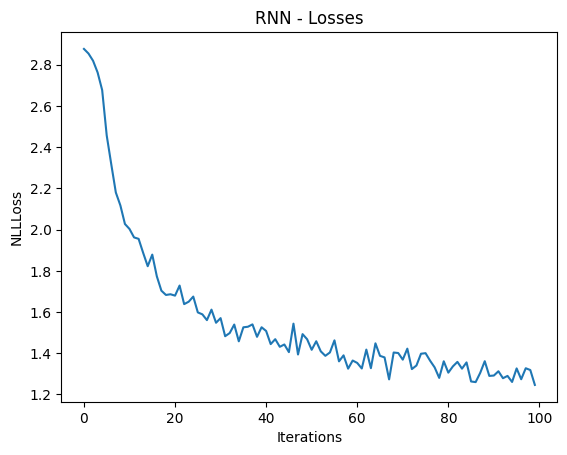

In [92]:
print_losses(rnn_losses, 'RNN - Losses')

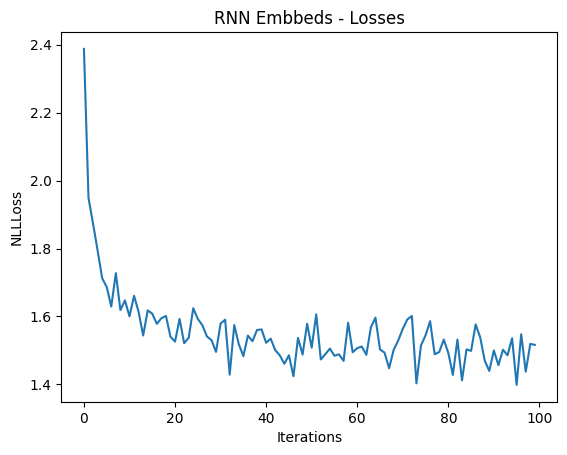

In [93]:
print_losses(rnn_embeds_losses, 'RNN Embbeds - Losses')

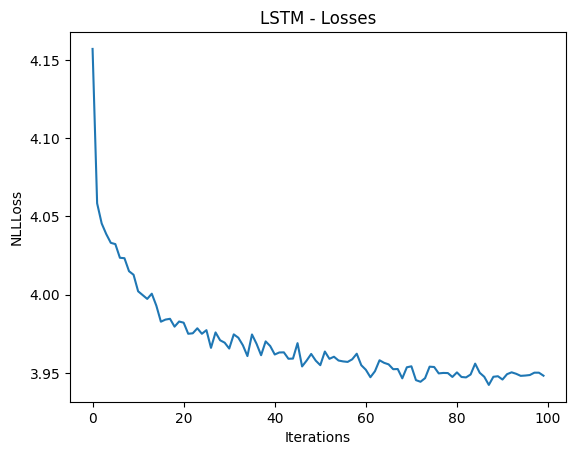

In [94]:
print_losses(lstm_losses, 'LSTM - Losses')

In [95]:
# Just return an output given a line
def evaluate(line_tensor, model):
    hidden = model.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output

def create_confusion_matrix(model):
  # Keep track of correct guesses in a confusion matrix
  confusion = torch.zeros(n_categories, n_categories)
  n_confusion = 10000

  # Go through a bunch of examples and record which are correctly guessed
  for i in range(n_confusion):
      category, line, category_tensor, line_tensor = randomTrainingExample(model.type_layer)
      output = evaluate(line_tensor, model)
      guess, guess_i = categoryFromOutput(output)
      category_i = all_categories.index(category)
      confusion[category_i][guess_i] += 1

  # Normalize by dividing every row by its sum
  for i in range(n_categories):
      confusion[i] = confusion[i] / confusion[i].sum()

  # Set up plot
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(confusion.numpy())
  fig.colorbar(cax)

  # Set up axes
  ax.set_xticklabels([''] + all_categories, rotation=90)
  ax.set_yticklabels([''] + all_categories)

  # Force label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  # sphinx_gallery_thumbnail_number = 2
  plt.show()

<ipython-input-95-ee740ff3592a>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-95-ee740ff3592a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


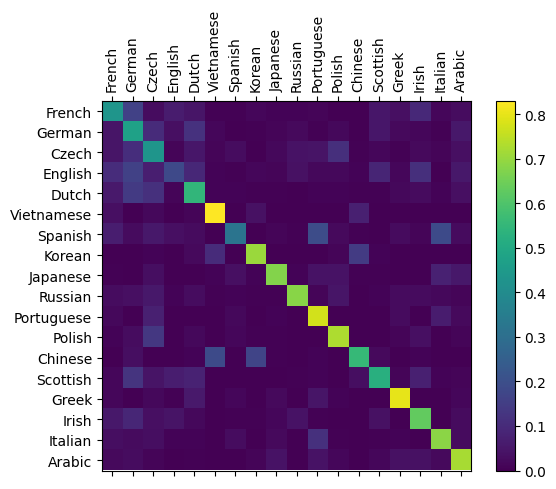

In [96]:
create_confusion_matrix(rnn)

<ipython-input-95-ee740ff3592a>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-95-ee740ff3592a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


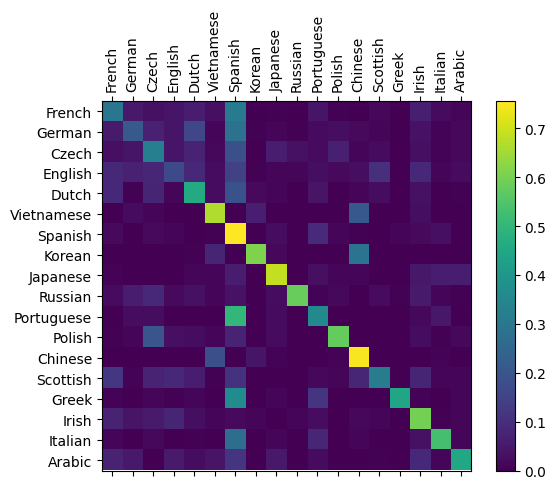

In [97]:
create_confusion_matrix(rnn_embeds)

In [100]:
create_confusion_matrix(lstm)

IndexError: ignored

# Question 6
Make a function to extract the embedding and visualise in the 2D space with the color w.r.t. the Language class. Feel free to modify the `get_embeddings()` function to return what you think could be useful for the plotting. Let's use also the cosine similarity between the embeddings to see if the embedding has a sense.

In [101]:
def getTrainingSample(word, model):
    # create a long tensor with the index of the language
    if model.type_layer == 'linear': word_tensor = wordToOneHotTensor(word)
    else: word_tensor = wordToEmbedding(word)
    return word_tensor

In [102]:
name_to_lang = {}
for lang, list_names in category_words.items():
  for name in list_names:
    name_to_lang[name] = lang
len(name_to_lang)

17458

In [103]:
def get_embedding(name_to_lang: dict, model):

  #if model.__class__.__name__ == 'RNN': hiddens = torch.matmul(model.i2h.weight.cpu().detach().T[:n_letters, :], model.h2o.weight.cpu().detach().T)
  #elif model.__class__.__name__  == 'RNN_mb': hiddens = torch.matmul(model.i2h.weight.cpu().detach().T[:n_letters, :], model.h2o.weight.cpu().detach().T)
  #else: pass

  hiddens, words, languages = np.empty((0,128)), list(name_to_lang.keys()), list(name_to_lang.values())

  rnn.eval()  # Set the model in evaluation mode

  # Extract hidden states from your dataset
  # Assuming you have a dataset of sequences, you can iterate over them and collect the hidden states

  # Iterate over your dataset and extract hidden states
  for name, _ in name_to_lang.items():
      hidden = rnn.initHidden()

      tensor_name = getTrainingSample(name, model)

      #sequence_hidden_states = np.empty((0, 128))

      for i in range(tensor_name.size(0)):

          with torch.no_grad():
            _, hidden = model(tensor_name[i], hidden)
            #if model.__class__.__name__ == "LSTM": output = model.log_softmax(output)
            #sequence_hidden_states.append(hidden.squeeze().numpy())
            #if not torch.all(hidden == 0):
              #print(hidden.shape)
              #print(sequence_hidden_states.size, hidden.numpy().shape)
            #sequence_hidden_states = np.vstack((sequence_hidden_states, hidden.numpy()))



      #print(sequence_hidden_states.shape)

      #hiddens.append(sequence_hidden_states)
      #print(np.sum(sequence_hidden_states, axis=0).shape)
      hiddens = np.vstack((hiddens, hidden))

  # Convert the list of hidden states to a NumPy array


  return hiddens, words, languages

In [122]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity


def print_embeddings(model, indices, name_to_lang):
  hiddens, words, languages = get_embedding(name_to_lang, rnn)

  colors = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'white', 'gray', 'orange', 'purple', 'brown', 'pink', 'teal', 'olive', 'indigo', 'violet', 'gold']

  tsne = TSNE()
  #embed_tsne = tsne.fit_transform(hiddens.squeeze()[:,:])
  embed_tsne = tsne.fit_transform(hiddens.squeeze()[indices,:])

  fig, ax = plt.subplots(figsize=(12, 12))
  for i, val in enumerate(indices):
      key_index = list(category_words.keys()).index(languages[val])

      plt.scatter(*embed_tsne[i, :], color=colors[key_index])
      plt.annotate(words[val]+' ('+languages[val]+')', (embed_tsne[i, 0], embed_tsne[i, 1]), alpha=0.7)

  plt.show()
  sim = cosine_similarity(hiddens)
  np.fill_diagonal(sim, -1.0)
  return sim

In [123]:
viz_words = 100
indices = np.random.choice(len(name_to_lang), viz_words)

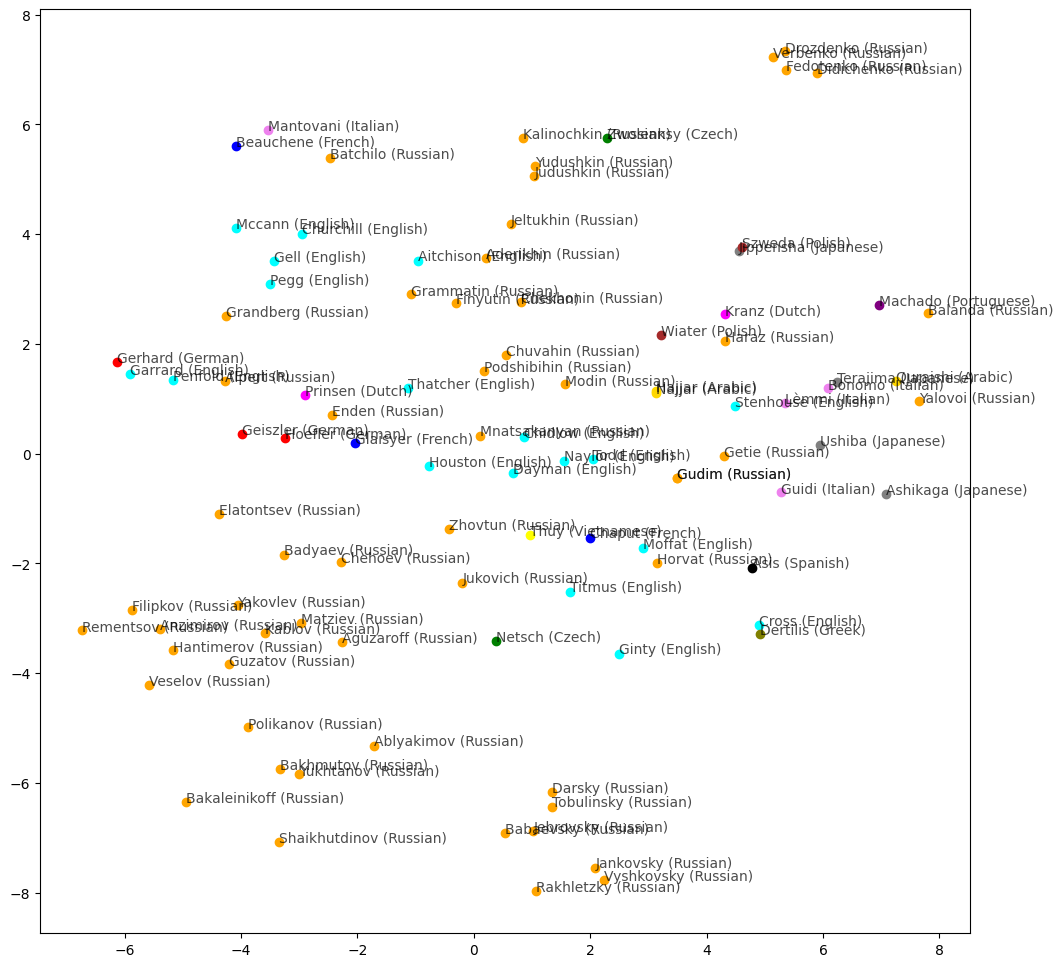

In [124]:
sim_rnn = print_embeddings(rnn, indices, name_to_lang)

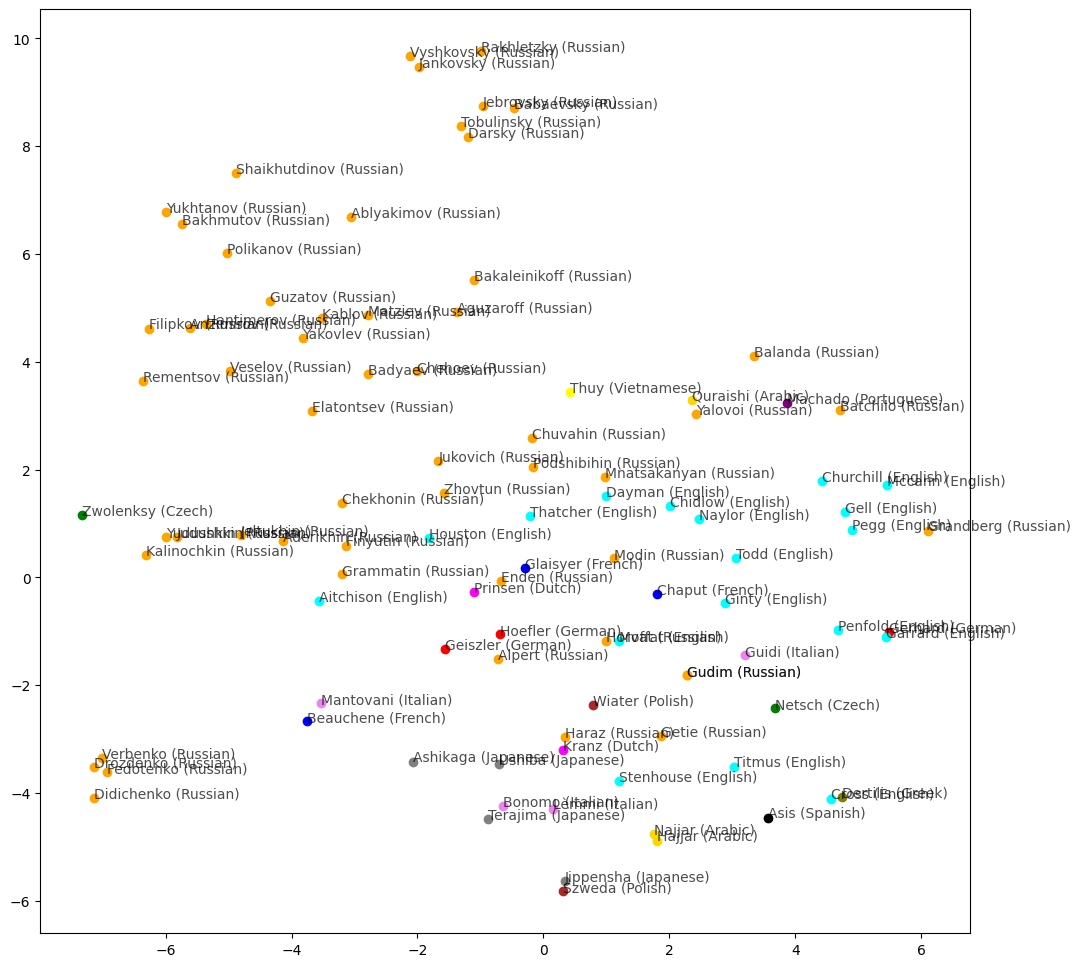

In [125]:
sim_rnn_embeds = print_embeddings(rnn_embeds, indices, name_to_lang)

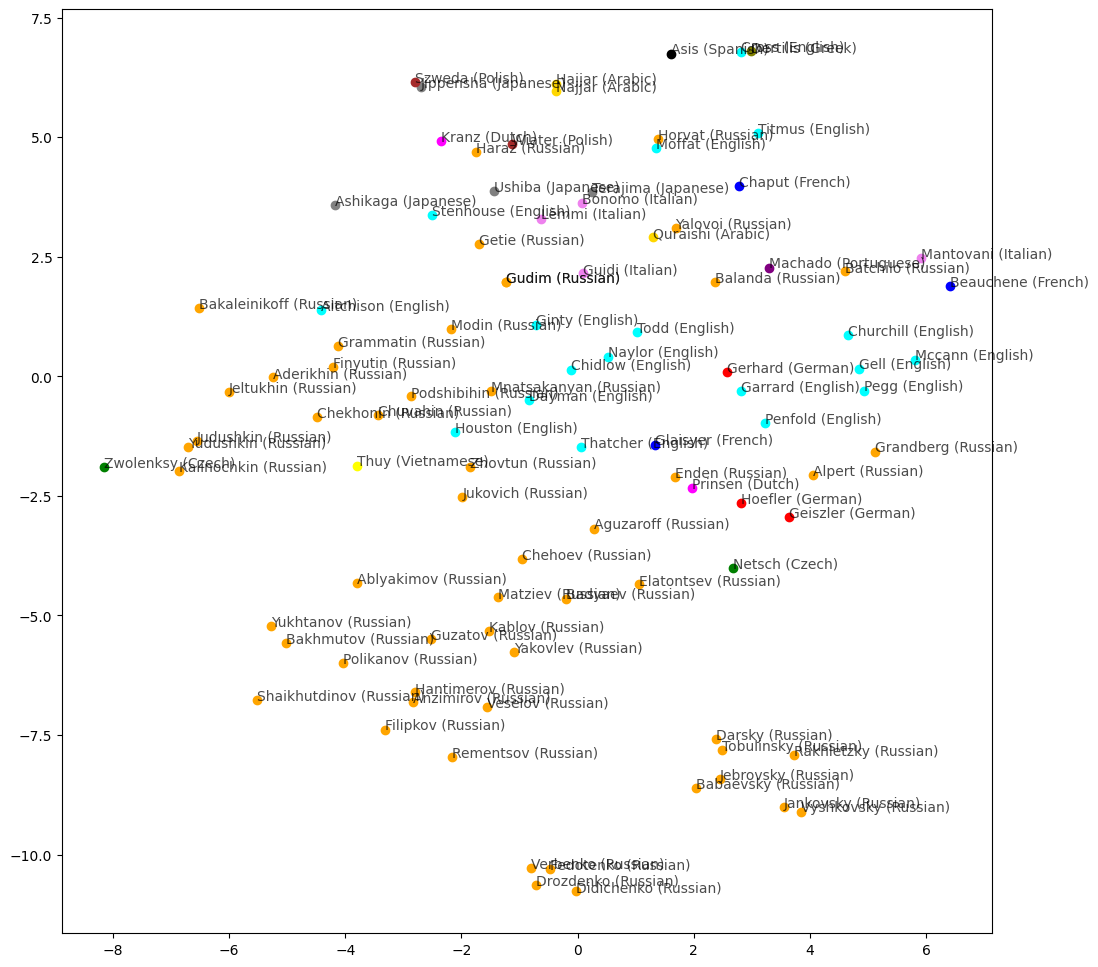

In [126]:
sim_lstm = print_embeddings(lstm, indices, name_to_lang)

In [139]:
def get_names_similarity(embedds_similarity, n_words, top_k):
  dict_to_return = {}
  range_embedds = range(len(embedds_similarity))
  idx_random_names = random.sample(range_embedds, n_words)
  keys = list(name_to_lang.keys())

  for idx_name in idx_random_names:
    name = keys[idx_name]

    most_similar_words_idx = np.flip(np.argsort(embedds_similarity[idx_name]))[:top_k]
    most_similar_words_str = [keys[idx] for idx in most_similar_words_idx]
    most_similar_words_lan = [name_to_lang[keys[idx]] for idx in most_similar_words_idx]
    most_similar_words_sim = [embedds_similarity[idx_name, idx] for idx in most_similar_words_idx]

    dict_to_return[idx_name] = most_similar_words_idx

    print(f'Most similar name for "{name} - ({name_to_lang[name]})" are:\t{most_similar_words_str}')
    print(f'With corresponding languages:\t{most_similar_words_lan}')
    print(f'With corresponding indices:\t{most_similar_words_idx}')
    print(f'With corresponding Embedding Cosine Similarity of:\t{most_similar_words_sim}\n')

  return dict_to_return

In [143]:
_ = get_names_similarity(sim_rnn, 5, 5)

Most similar name for "Ashton - (English)" are:	['Wharton', 'Button', 'Utton', 'Etherton', 'Easton']
With corresponding languages:	['English', 'English', 'English', 'English', 'English']
With corresponding indices:	[4874 1828 4738 2383 2244]
With corresponding Embedding Cosine Similarity of:	[0.7908770561382749, 0.7833833582045433, 0.7793885140479258, 0.7790111618499147, 0.7783051750557178]

Most similar name for "Hanjonkov - (Russian)" are:	['Zimenkov', 'Ryjankov', 'Timiskov', 'Minenkov', 'Pirojkov']
With corresponding languages:	['Russian', 'Russian', 'Russian', 'Russian', 'Russian']
With corresponding indices:	[15915 13575 14111 12237 13039]
With corresponding Embedding Cosine Similarity of:	[0.9411503555886493, 0.9147202633515649, 0.9098205202929363, 0.9010218440036333, 0.8961705902487547]

Most similar name for "Judkovich - (Russian)" are:	['Yudkovich', 'Jivkovich', 'Jukovich', 'Minkovich', 'Dzhikovich']
With corresponding languages:	['Russian', 'Russian', 'Russian', 'Russian', 'R

In [144]:
_ = get_names_similarity(sim_rnn_embeds, 5, 5)

Most similar name for "Razygrin - (Russian)" are:	['Augustin', 'Jeryapin', 'Handorin', 'Shamardin', 'Poryadin']
With corresponding languages:	['German', 'Russian', 'Russian', 'Russian', 'Russian']
With corresponding indices:	[    8 11011 10222 13845 13237]
With corresponding Embedding Cosine Similarity of:	[0.7602235105236882, 0.754428325007508, 0.7521432732097084, 0.7489192527368986, 0.7400307751237617]

Most similar name for "Ohka - (Japanese)" are:	['Ooka', 'Toka', 'Chutko', 'Odaka', 'Tihenko']
With corresponding languages:	['Japanese', 'Russian', 'Russian', 'Japanese', 'Russian']
With corresponding indices:	[ 6333 14138  8737  6291 14057]
With corresponding Embedding Cosine Similarity of:	[0.8595554368337578, 0.8239793299045377, 0.7995210301657169, 0.7993107623029303, 0.7893001722980753]

Most similar name for "Alfionov - (Russian)" are:	['Adrianov', 'Agaponov', 'Vilonov', 'Darminov', 'Abdurahmanov']
With corresponding languages:	['Russian', 'Russian', 'Russian', 'Russian', 'Russia

In [145]:
_ = get_names_similarity(sim_lstm, 5, 5)

Most similar name for "D'angelo - (Italian)" are:	['Daugelo', 'Abbatangelo', 'Abatangelo', 'Cabello', 'Balagula']
With corresponding languages:	['Russian', 'Italian', 'Italian', 'Spanish', 'Russian']
With corresponding indices:	[ 8820 16703 16695  5390  8124]
With corresponding Embedding Cosine Similarity of:	[0.8967707133284392, 0.8397213742105736, 0.8151001109008714, 0.7785013844823465, 0.7574658648180808]

Most similar name for "Kopp - (Czech)" are:	['Knopp', 'Knepp', 'Kemp', 'Yapp', 'Knopf']
With corresponding languages:	['German', 'German', 'English', 'English', 'German']
With corresponding indices:	[ 596  593 3185 4987  595]
With corresponding Embedding Cosine Similarity of:	[0.8923872042087523, 0.8250680355043141, 0.795312483334276, 0.7806830287985574, 0.7720060639235139]

Most similar name for "Bajov - (Russian)" are:	['Vajov', 'Habov', 'Basov', 'Zobov', 'Abov']
With corresponding languages:	['Russian', 'Russian', 'Russian', 'Russian', 'Russian']
With corresponding indices:	[14